# Correlations
## Import Data

In [1]:
import pandas as pd

In [2]:
# load preprocessed data from csv file
X_train_transformed = pd.read_csv('../data/X_train_transformed.csv')
y_train = pd.read_csv('../data/y_train.csv')
model = pd.read_csv('../data/final_model_ALL_20230525.csv')

In [3]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25149 entries, 0 to 25148
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   highest_education            25149 non-null  float64
 1   imd_band                     25149 non-null  float64
 2   age_band                     25149 non-null  float64
 3   code_module_AAA              25149 non-null  bool   
 4   code_module_BBB              25149 non-null  bool   
 5   code_module_CCC              25149 non-null  bool   
 6   code_module_DDD              25149 non-null  bool   
 7   code_module_EEE              25149 non-null  bool   
 8   code_module_FFF              25149 non-null  bool   
 9   code_module_GGG              25149 non-null  bool   
 10  code_presentation_2013B      25149 non-null  bool   
 11  code_presentation_2013J      25149 non-null  bool   
 12  code_presentation_2014B      25149 non-null  bool   
 13  code_presentatio

## Correlation Plot

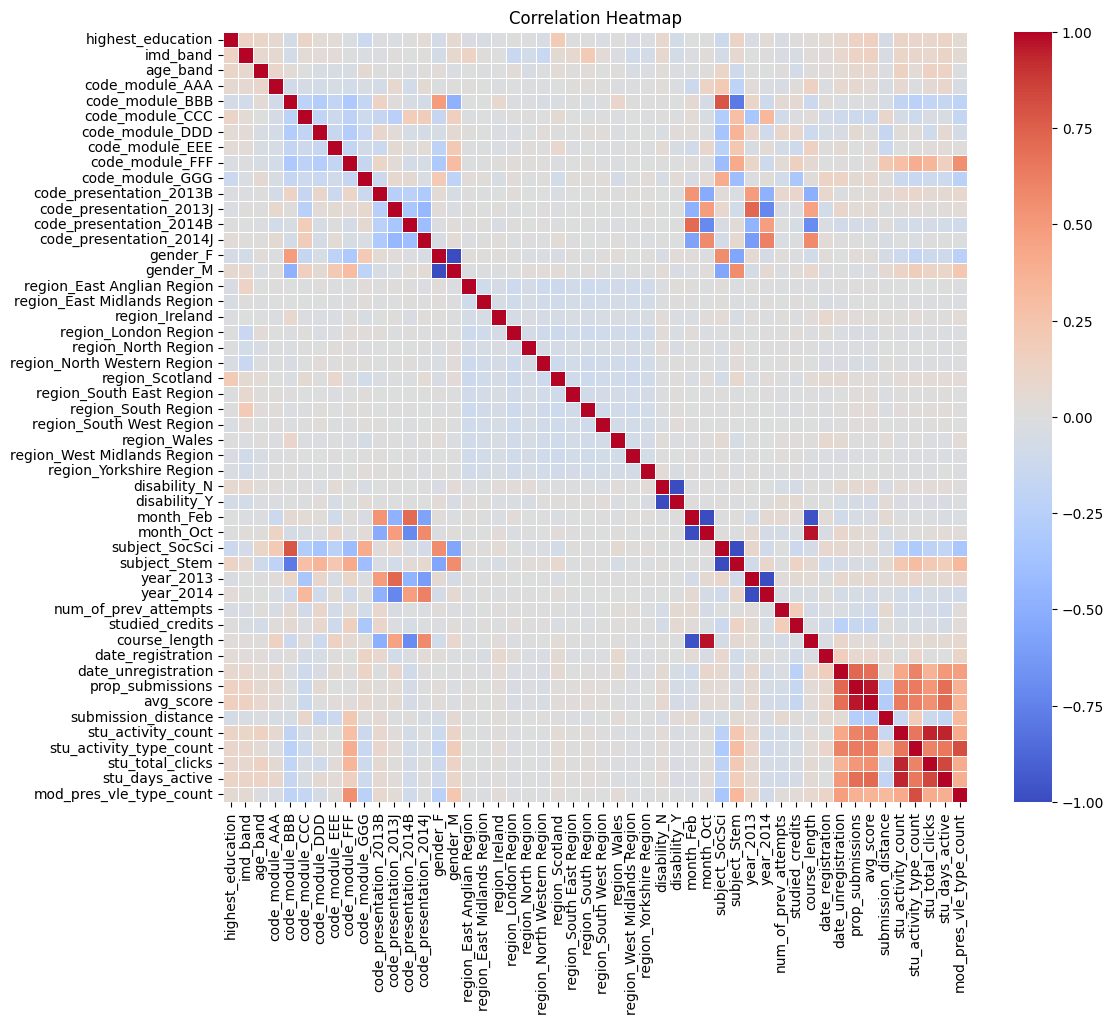

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

# correlation matrix
correlation_matrix = X_train_transformed.corr()

# heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()



So there are currently 50 features but there is a lot of collinearity, redundancy - that is because many features are based on each other or similar data.  For example, that `month_Oct` and `month_Feb` have a strong negative correlation makes sense - most students are enrolled on one module presentation and as such will have a 0 in the other feature.  This goes for other pairs like `gender`, `subject`, `disability`, etc.  - you are one, not the other.  Then there is correlation (redundant) between year and presentation which contains the year.  

Aside from these obvious correlations, there is a lot of grey - no correlation whatsoever and faint - very weak association.  For example, module FFF is weakly positively correlated with student clicks and activity count - essentially, this means that module FFF had more vle activity available to the students.  Region appears to have no correlation with any other variables - so will probably be removed. 

The interesting corner is in the bottom right - where there are strong correlations between features.  This makes sense as they are all measures of engagement.

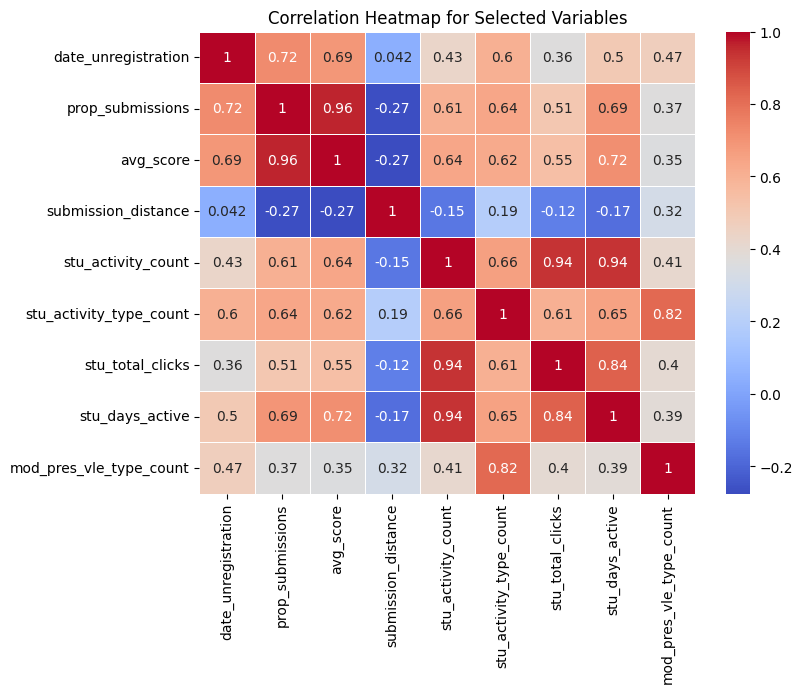

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# variables with strong positive correlations
selected_vars = ['date_unregistration', 'prop_submissions', 'avg_score',
                 'submission_distance', 'stu_activity_count', 
                 'stu_activity_type_count', 'stu_total_clicks',
                 'stu_days_active', 'mod_pres_vle_type_count']

# correlation matrix for selected variables
selected_corr_matrix = X_train_transformed[selected_vars].corr()

# heatmap for selected variables
plt.figure(figsize=(8, 6))
sns.heatmap(selected_corr_matrix, annot = True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Heatmap for Selected Variables')
plt.show()


There are obvious high correlations here - for example average score with proportion of assessments submitted, total clicks and activity count, etc.

In [6]:
model.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31437 entries, 0 to 31436
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   code_module              31437 non-null  object 
 1   code_presentation        31437 non-null  object 
 2   id_student               31437 non-null  int64  
 3   gender                   31437 non-null  object 
 4   region                   31437 non-null  object 
 5   highest_education        31437 non-null  object 
 6   imd_band                 31437 non-null  object 
 7   age_band                 31437 non-null  object 
 8   num_of_prev_attempts     31437 non-null  int64  
 9   studied_credits          31437 non-null  int64  
 10  disability               31437 non-null  object 
 11  course_length            31437 non-null  int64  
 12  date_registration        31437 non-null  float64
 13  date_unregistration      31437 non-null  float64
 14  prop_submissions      

## Correlation plot using original dataframe

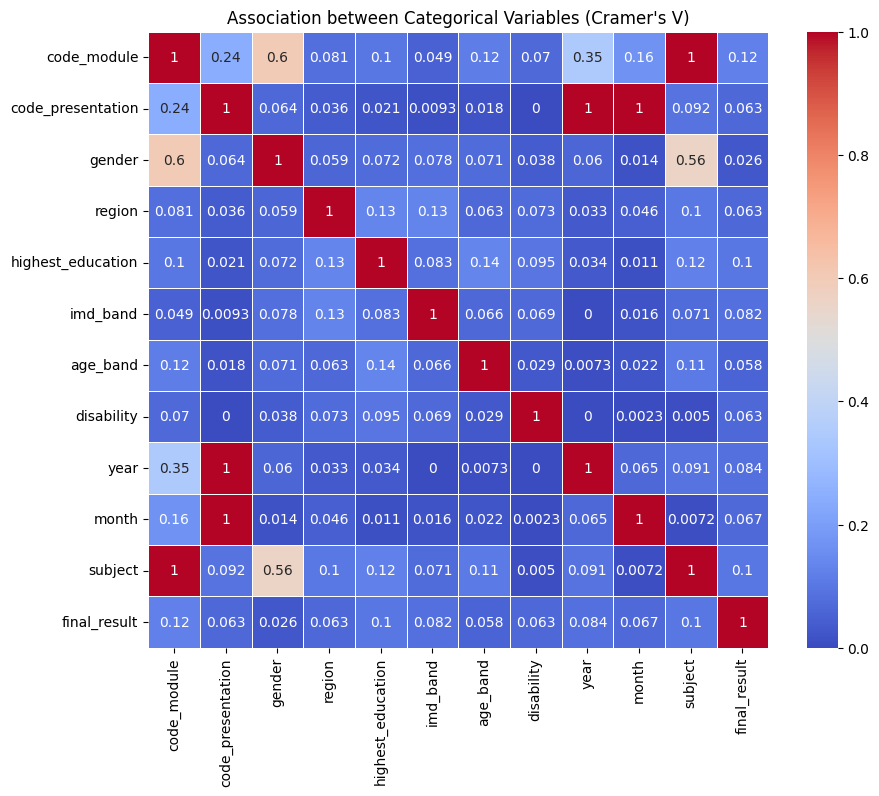

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder

# ategorical columns for association analysis
categorical_cols = ['code_module', 'code_presentation', 'gender', 'region', 'highest_education',
                    'imd_band', 'age_band', 'disability', 'year', 'month', 'subject', 'final_result']

# subset 
data_subset = model[categorical_cols]

# encode 
label_encoder = LabelEncoder()
data_encoded = data_subset.apply(label_encoder.fit_transform)

# Cramer's V for each pair of categorical variables
cramer_v_matrix = pd.DataFrame(index=data_encoded.columns, columns=data_encoded.columns)

for col1 in data_encoded.columns:
    for col2 in data_encoded.columns:
        confusion_matrix = pd.crosstab(data_encoded[col1], data_encoded[col2])
        chi2, _, _, _ = chi2_contingency(confusion_matrix)
        n = confusion_matrix.sum().sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k - 1) * (r - 1)) / (n - 1))
        rcorr = r - ((r - 1) ** 2) / (n - 1)
        kcorr = k - ((k - 1) ** 2) / (n - 1)
        cramer_v = np.sqrt(phi2corr / min((kcorr - 1), (rcorr - 1)))
        cramer_v_matrix.loc[col1, col2] = cramer_v

# replace NaN values with 0
cramer_v_matrix = cramer_v_matrix.fillna(0)

# plot 
plt.figure(figsize=(10, 8))
sns.heatmap(cramer_v_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title("Association between Categorical Variables (Cramer's V)")
plt.show()




In terms of the categorical variables - there is not much association between the features - there's a lot of blue.  Of note, gender and subject are correlated - it turns out that more Females study Social Sciences and Male students study STEM.

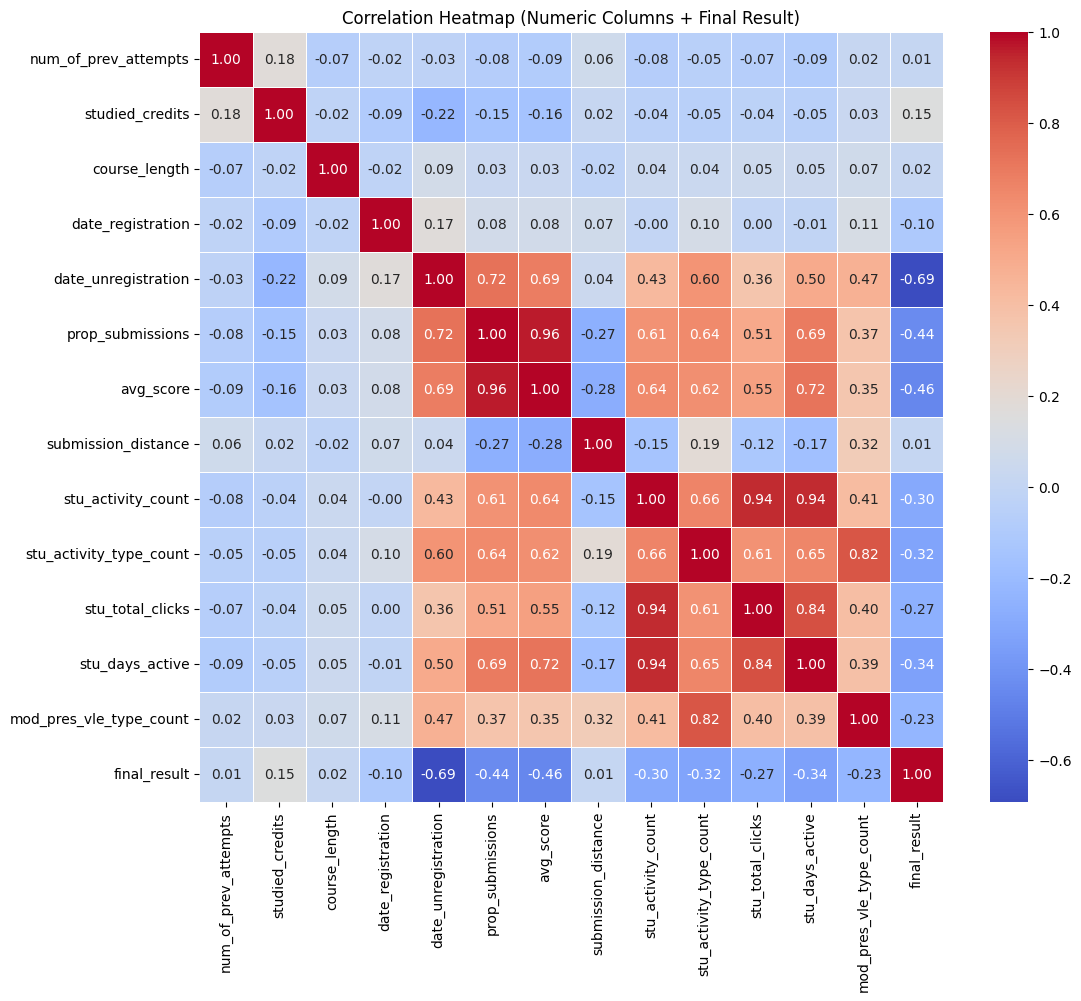

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Relevant columns for correlation analysis
numeric_cols = ['num_of_prev_attempts', 'studied_credits', 'course_length', 'date_registration',
                'date_unregistration', 'prop_submissions', 'avg_score', 'submission_distance',
                'stu_activity_count', 'stu_activity_type_count', 'stu_total_clicks',
                'stu_days_active', 'mod_pres_vle_type_count']

non_numeric_cols = ['final_result']

# Select the relevant columns from the dataset
data_subset = model[numeric_cols + non_numeric_cols].copy()

# Encode the non-numeric column 'final_result'
data_subset['final_result'] = data_subset['final_result'].astype('category').cat.codes

# Correlation matrix
corr_matrix = data_subset.corr()

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap (Numeric Columns + Final Result)')
plt.show()



## Pair Plots

In [9]:
# this does not complete (10- too many pairs, too much redundant information



# concatenate the training data and the target variable
#train = pd.concat([X_train_transformed, y_train], axis=1)

# pair plot
#sns.pairplot(train, hue='final_result')
#plt.title('Pair Plot')
#plt.show()


In [27]:
X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25149 entries, 0 to 25148
Data columns (total 50 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   highest_education            25149 non-null  float64
 1   imd_band                     25149 non-null  float64
 2   age_band                     25149 non-null  float64
 3   code_module_AAA              25149 non-null  bool   
 4   code_module_BBB              25149 non-null  bool   
 5   code_module_CCC              25149 non-null  bool   
 6   code_module_DDD              25149 non-null  bool   
 7   code_module_EEE              25149 non-null  bool   
 8   code_module_FFF              25149 non-null  bool   
 9   code_module_GGG              25149 non-null  bool   
 10  code_presentation_2013B      25149 non-null  bool   
 11  code_presentation_2013J      25149 non-null  bool   
 12  code_presentation_2014B      25149 non-null  bool   
 13  code_presentatio

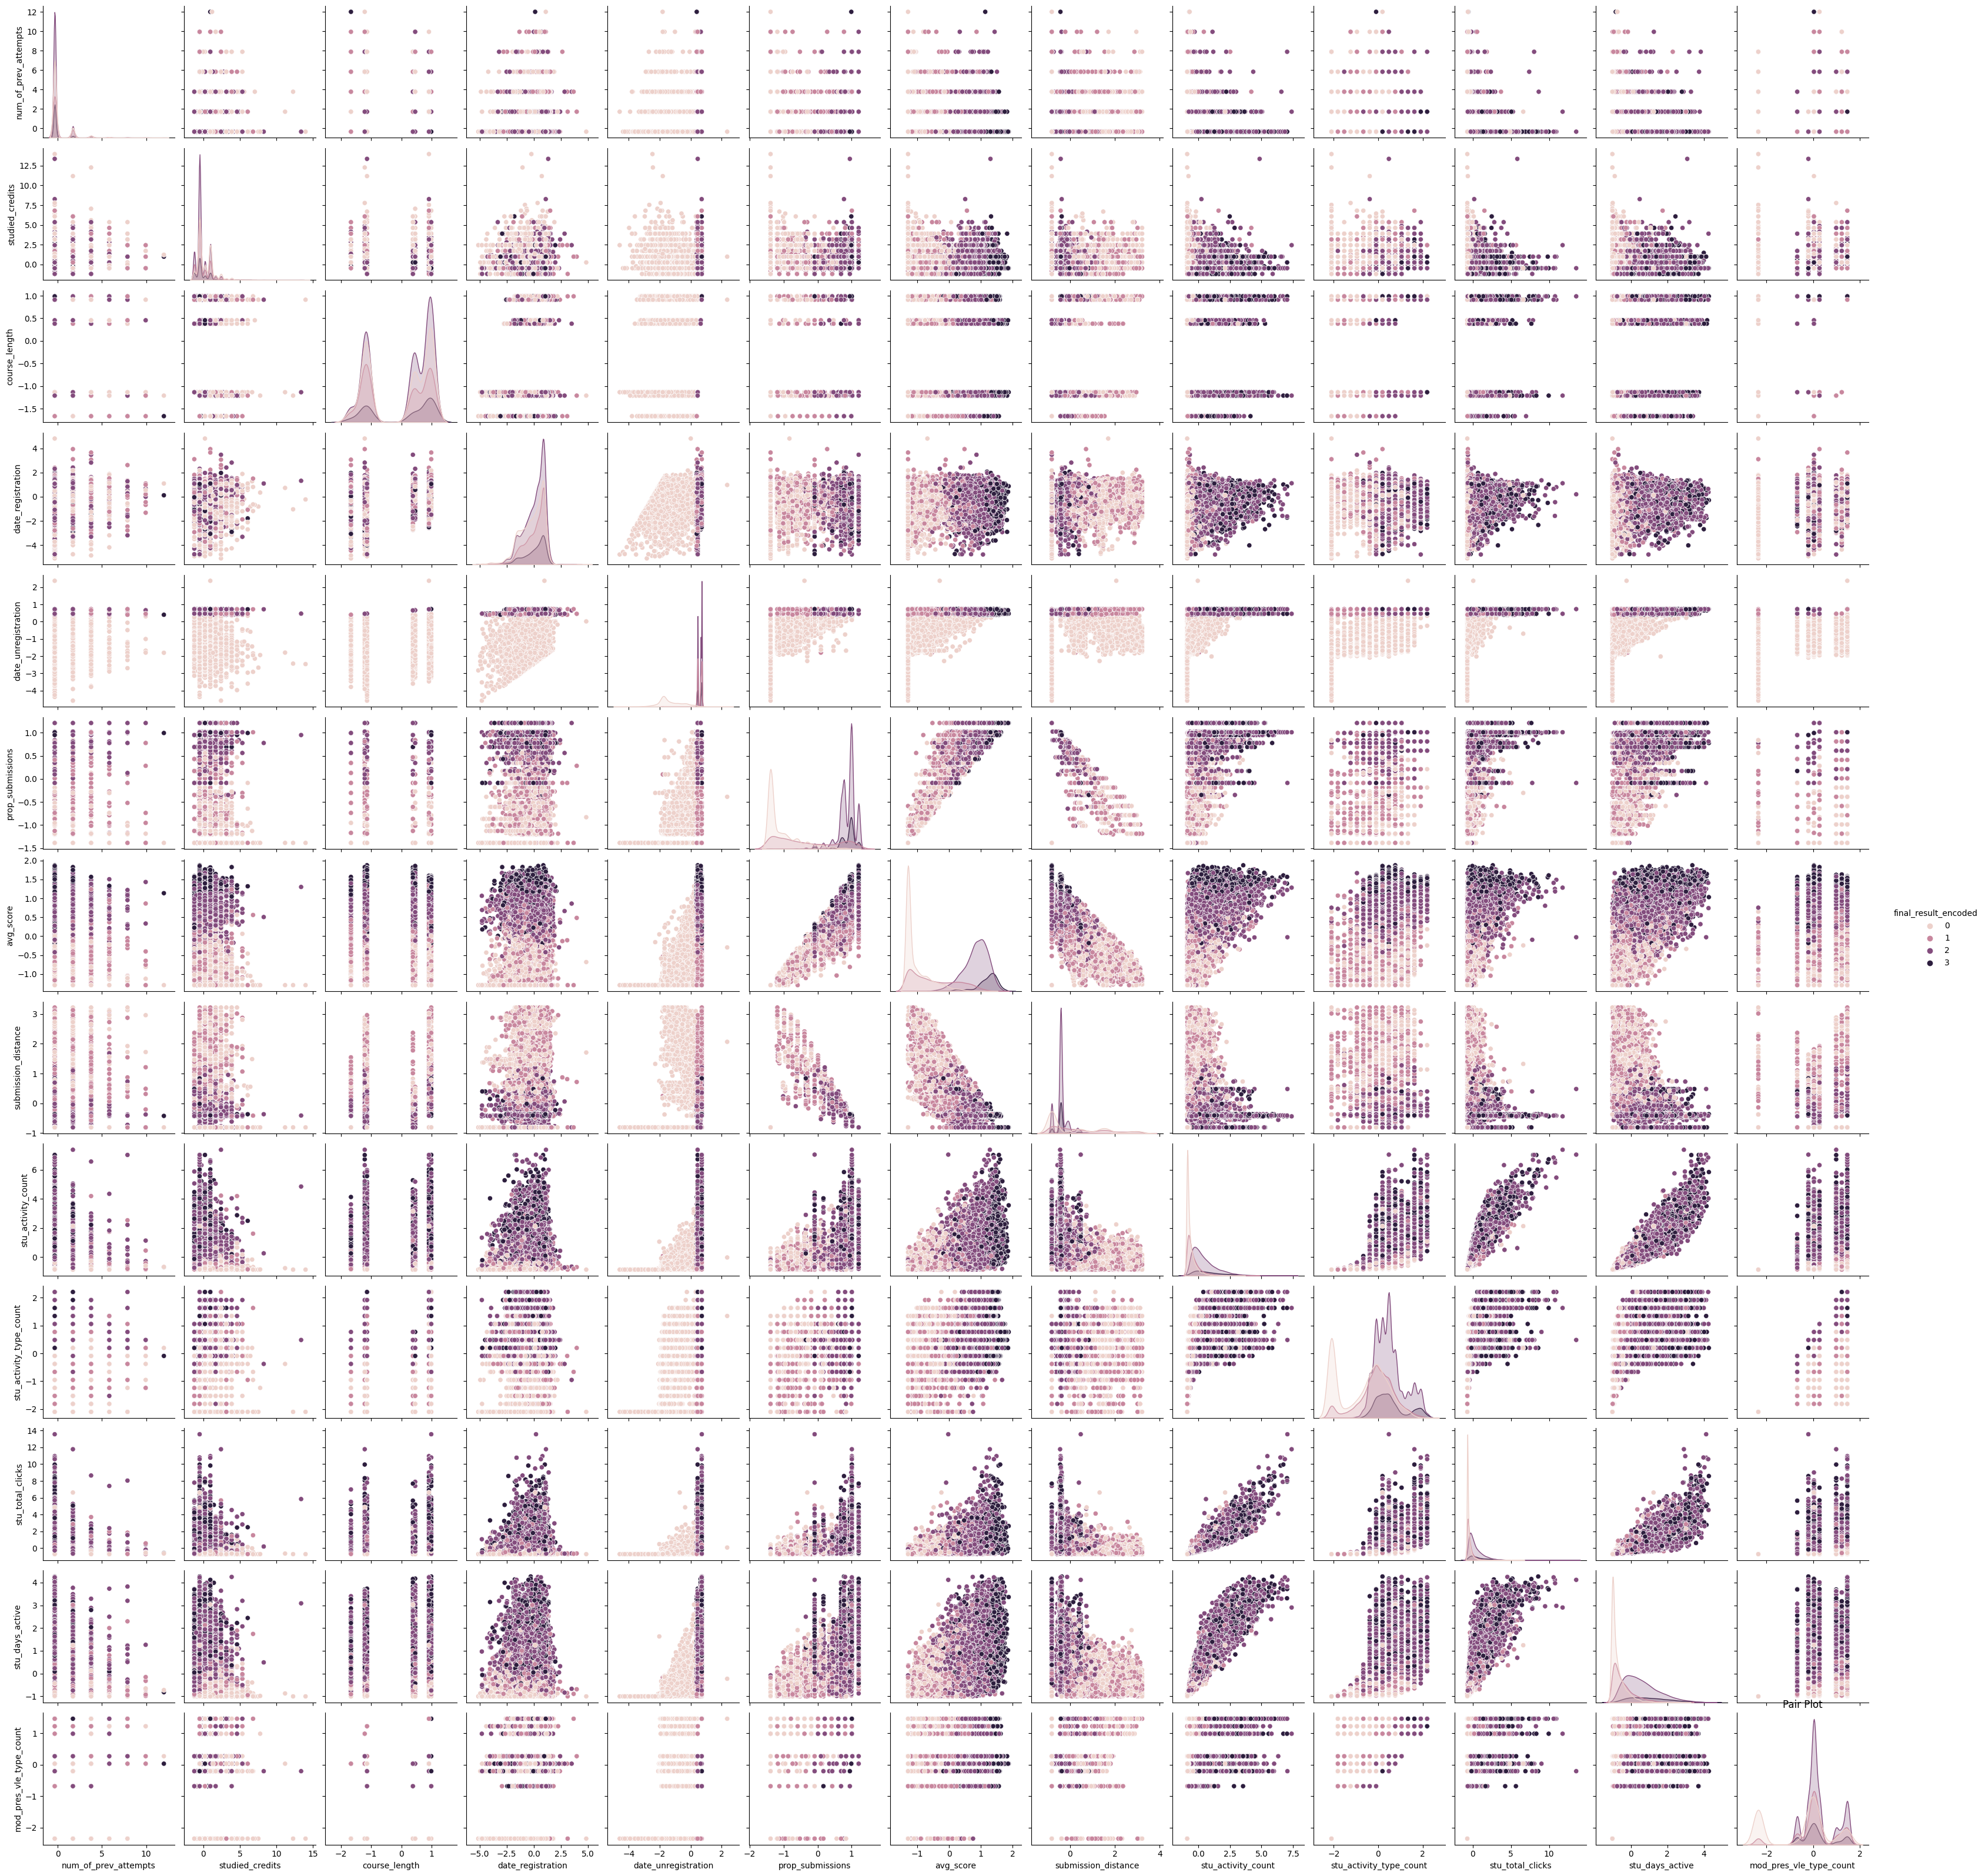

In [28]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# numeric columns and the 'final_result' column
subset_train = pd.concat([X_train_transformed[numeric_cols], y_train], axis=1)

# 'final_result' column ordinal encoding
ordinal_mapping = {'Withdrawn': 0, 'Fail': 1, 'Pass': 2, 'Distinction': 3}
subset_train['final_result_encoded'] = subset_train['final_result'].map(ordinal_mapping)

# pair plot
sns.pairplot(subset_train, hue='final_result_encoded')
plt.title('Pair Plot')
plt.show()



### VIF Variance Inflation Factor - checking for multicollinearity

I used two different methods for calculating VIF as I was having some trouble with data types.  VIF measures multicollinearity - essentially the extent to which a predictor variable can be explained by other predictor variables.  I am expecting there to be some significant multicollinearity because of the feature creation and the relation between the features.  The first method uses `variable_inflation_factor` from `statsmodels` where VIF is calculated using linear regression.  The second is more of a manual approach where $VIF = 1 / (1 - R^2)$ where $R^2$ is the coefficient of determination from simple linear regression.

In [38]:
#X_train_transformed.info()
#X_train_transformed.isna().sum()

X_train_transformed = X_train_transformed.apply(pd.to_numeric, errors='coerce')



non_numeric_cols = X_train_transformed.columns[~X_train_transformed.apply(pd.to_numeric, errors='coerce').notnull().all()]
print(non_numeric_cols)





Index([], dtype='object')


In [44]:
print(X_train_transformed.dtypes)



highest_education              float64
imd_band                       float64
age_band                       float64
code_module_AAA                   bool
code_module_BBB                   bool
code_module_CCC                   bool
code_module_DDD                   bool
code_module_EEE                   bool
code_module_FFF                   bool
code_module_GGG                   bool
code_presentation_2013B           bool
code_presentation_2013J           bool
code_presentation_2014B           bool
code_presentation_2014J           bool
gender_F                          bool
gender_M                          bool
region_East Anglian Region        bool
region_East Midlands Region       bool
region_Ireland                    bool
region_London Region              bool
region_North Region               bool
region_North Western Region       bool
region_Scotland                   bool
region_South East Region          bool
region_South Region               bool
region_South West Region 

In [46]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

vif = calculate_vif(X_train_transformed)
print(vif)


/home/codespace/.python/current/lib/python3.10/site-packages/statsmodels/stats/outliers_influence.py:198: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                        Feature        VIF
0             highest_education   1.147352
1                      imd_band   1.194051
2                      age_band   1.090062
3               code_module_AAA        inf
4               code_module_BBB        inf
5               code_module_CCC        inf
6               code_module_DDD        inf
7               code_module_EEE        inf
8               code_module_FFF        inf
9               code_module_GGG        inf
10      code_presentation_2013B        inf
11      code_presentation_2013J        inf
12      code_presentation_2014B        inf
13      code_presentation_2014J        inf
14                     gender_F        inf
15                     gender_M        inf
16   region_East Anglian Region        inf
17  region_East Midlands Region        inf
18               region_Ireland        inf
19         region_London Region        inf
20          region_North Region        inf
21  region_North Western Region        inf
22         

### Logistic Regression

In [55]:
y_encoded

Fail   Pass  Withdrawn
0       True  False      False
1       True  False      False
2       True  False      False
3       True  False      False
4      False   True      False
...      ...    ...        ...
25144  False   True      False
25145  False  False       True
25146  False   True      False
25147  False   True      False
25148  False  False       True

[25149 rows x 3 columns]

In [64]:
from sklearn.linear_model import LogisticRegression
import numpy as np

# target variable into ordinal encoding
ordinal_mapping = {'Withdrawn': 0, 'Fail': 1, 'Pass': 2, 'Distinction': 3}
y_encoded = y_train['final_result'].map(ordinal_mapping)

# fit logistic regression model
logreg_model = LogisticRegression(max_iter=1000)
logreg_model.fit(X_train_transformed, y_encoded)

# coefficients and p-values for each independent variable
coefficients = logreg_model.coef_
p_values = np.squeeze(logreg_model.predict_proba(X_train_transformed))

# results
for i, column in enumerate(X_train_transformed.columns):
    print(f"Variable: {column}, Coefficient: {coefficients[0][i]}, p-value: {p_values[i]}")






Variable: highest_education, Coefficient: -0.13747981216240224, p-value: [0.01095768 0.57505656 0.40535959 0.00862616]
Variable: imd_band, Coefficient: -0.008250077895769186, p-value: [2.22025021e-02 9.62987335e-01 1.40877877e-02 7.22375025e-04]
Variable: age_band, Coefficient: 0.18067263412838527, p-value: [2.85082859e-02 9.71243134e-01 2.46831914e-04 1.74812612e-06]
Variable: code_module_AAA, Coefficient: 0.025696281454550246, p-value: [0.00335283 0.07124066 0.91918568 0.00622083]
Variable: code_module_BBB, Coefficient: 0.07058322618039639, p-value: [5.79006152e-04 4.29280429e-02 8.61498891e-01 9.49940603e-02]
Variable: code_module_CCC, Coefficient: -0.5355402988814284, p-value: [8.78384759e-03 9.88349881e-01 2.80071577e-03 6.55557763e-05]
Variable: code_module_DDD, Coefficient: 0.6027649236816627, p-value: [6.39813764e-05 1.87296890e-04 1.36289037e-01 8.63459685e-01]
Variable: code_module_EEE, Coefficient: -0.22227868648908344, p-value: [6.94447284e-04 2.96832711e-02 9.42188600e-01 

Features with positive coefficients, indicating a positive relationship with the outcome

age_band, code_module_BBB, code_module_FFF, region_East Midlands Region, region_South Region, region_West Midlands Region, region_Yorkshire Region, subject_Stem, course_length, prop_submissions, stu_days_active


Features with negative coefficients, suggesting a negative relationship with the outcome

highest_education, code_module_CCC, code_module_EEE, code_module_GGG, code_presentation_2013J, region_North Region, region_South East Region, region_South West Region, disability_N, month_Oct, subject_SocSci, year_2013, num_of_prev_attempts, date_registration, avg_score, stu_activity_type_count, stu_total_clicks


Features with both positive and negative coefficients, indicating that their relationship with the outcome  varies on the specific values or conditions

code_module_AAA, code_presentation_2013B, code_presentation_2014J, gender_F, region_North Western Region, region_Scotland, region_Wales, stu_activity_count, mod_pres_vle_type_count, studied_credits, year_2014, submission_distance: 







### Regularisation


In [65]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import SelectFromModel

# Lasso or Ridge regression models
lasso_model = Lasso(alpha=0.1)  
ridge_model = Ridge(alpha=0.1)  

# fit the models 
lasso_model.fit(X_train_transformed, y_encoded)
ridge_model.fit(X_train_transformed, y_encoded)

# Get the selected features based on non-zero coefficients
lasso_selected_features = X_train_transformed.columns[lasso_model.coef_ != 0]
ridge_selected_features = X_train_transformed.columns[ridge_model.coef_ != 0]

# Print the selected features
print("Lasso selected features:", lasso_selected_features)
print("Ridge selected features:", ridge_selected_features)


Lasso selected features: Index(['date_unregistration', 'avg_score', 'submission_distance'], dtype='object')
Ridge selected features: Index(['highest_education', 'imd_band', 'age_band', 'code_module_AAA',
       'code_module_BBB', 'code_module_CCC', 'code_module_DDD',
       'code_module_EEE', 'code_module_FFF', 'code_module_GGG',
       'code_presentation_2013B', 'code_presentation_2013J',
       'code_presentation_2014B', 'code_presentation_2014J', 'gender_F',
       'gender_M', 'region_East Anglian Region', 'region_East Midlands Region',
       'region_Ireland', 'region_London Region', 'region_North Region',
       'region_North Western Region', 'region_Scotland',
       'region_South East Region', 'region_South Region',
       'region_South West Region', 'region_Wales',
       'region_West Midlands Region', 'region_Yorkshire Region',
       'disability_N', 'disability_Y', 'month_Feb', 'month_Oct',
       'subject_SocSci', 'subject_Stem', 'year_2013', 'year_2014',
       'num_of_prev